## Taxi data set analysis

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

The key aspect of ride-hailing is the price. It relies on technology to collect accurate tracking data so that a fair price can be calculated at the end of the trip. Fortunately, our riders are quick to tell us when they overpaid and we can use that feedback to improve our product.

**Please analyze the dataset to identify top opportunities for reducing the number of overcharge tickets and present your results.**

Variables in the file:

order_id_new, order_try_id_new - id of an order

calc_created- time when the order was created

metered_price, distance, duration- actual price, distance and duration of a ride

upfront_price- promised to the rider price, based on predicted duration (predicted_duration) and distance (predicted_distance)

distance - ride distance

duration - ride duration

gps_confidence- indicator for good GPS connection (1 - good one, 0 - bad one)

entered_by- who entered the address

b_state- state of a ride (finished implies that the ride was actually done)

dest_change_number- number of destination changes by a rider

predicted distance - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car

predicted duration - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car

prediction_price_type- internal variable for the type of prediction:

upfront, prediction - prediction happened before the ride

upfront_destination_changed - prediction happened after rider changed destination during the ride

change_reason_pricing - records due to whose action the price changed

ticket_id_new - id for customer support ticket

## Data loading and overview

In [2]:
df = pd.read_csv('/Users/starburned/data_analytics_projects/data/Analytical_Task_Taxi.csv')

In [3]:
df.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


In [8]:
len(df)

4943

In [7]:
df.columns

Index(['order_id_new', 'order_try_id_new', 'calc_created', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration', 'change_reason_pricing',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'overpaid_ride_ticket', 'fraud_score'],
      dtype='object')

In [6]:
df['overpaid_ride_ticket'].value_counts()

0    4606
1     337
Name: overpaid_ride_ticket, dtype: int64

In [18]:
df['calc_created'].agg(['min', 'max'])

min   2020-02-02 00:01:16
max   2020-03-13 23:52:07
Name: calc_created, dtype: datetime64[ns]

In [29]:
df['metered_price'].agg(['min', 'max'])

min         2.00
max    194483.52
Name: metered_price, dtype: float64

In [15]:
df.dtypes

order_id_new               int64
order_try_id_new           int64
calc_created              object
metered_price            float64
upfront_price            float64
distance                   int64
duration                   int64
gps_confidence             int64
entered_by                object
b_state                   object
dest_change_number         int64
prediction_price_type     object
predicted_distance       float64
predicted_duration       float64
change_reason_pricing     object
ticket_id_new              int64
device_token             float64
rider_app_version         object
order_state               object
order_try_state           object
driver_app_version        object
driver_device_uid_new      int64
device_name               object
eu_indicator               int64
overpaid_ride_ticket       int64
fraud_score              float64
dtype: object

In [4]:
df['calc_created'] = pd.to_datetime(df['calc_created'],format='%Y-%m-%d %H:%M:%S')

In [19]:
df.isna().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price              20
upfront_price            1534
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type      20
predicted_distance         20
predicted_duration         20
change_reason_pricing    4645
ticket_id_new               0
device_token             4943
rider_app_version          16
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2759
dtype: int64

In [20]:
df.isna().mean()

order_id_new             0.000000
order_try_id_new         0.000000
calc_created             0.000000
metered_price            0.004046
upfront_price            0.310338
distance                 0.000000
duration                 0.000000
gps_confidence           0.000000
entered_by               0.000000
b_state                  0.000000
dest_change_number       0.000000
prediction_price_type    0.004046
predicted_distance       0.004046
predicted_duration       0.004046
change_reason_pricing    0.939713
ticket_id_new            0.000000
device_token             1.000000
rider_app_version        0.003237
order_state              0.000000
order_try_state          0.000000
driver_app_version       0.000000
driver_device_uid_new    0.000000
device_name              0.000000
eu_indicator             0.000000
overpaid_ride_ticket     0.000000
fraud_score              0.558163
dtype: float64

## EDA

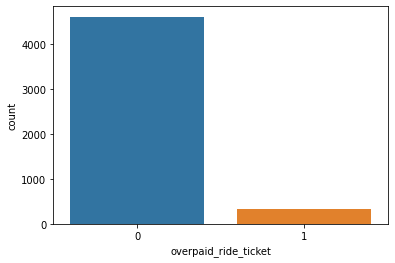

In [12]:
sns.countplot(data=df, x='overpaid_ride_ticket');

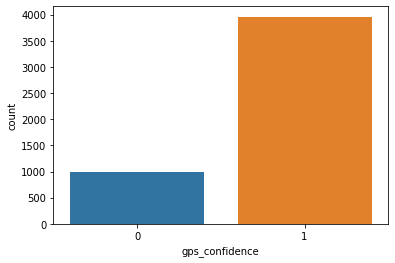

In [14]:
sns.countplot(data=df, x='gps_confidence');

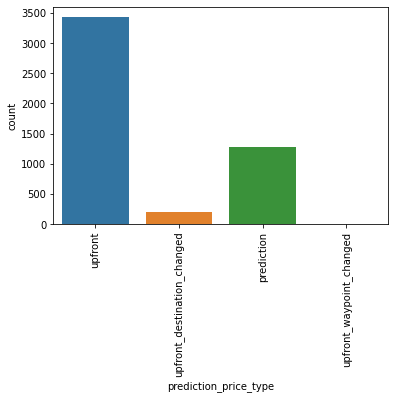

In [20]:
sns.countplot(data=df, x='prediction_price_type')
plt.xticks(rotation=90);

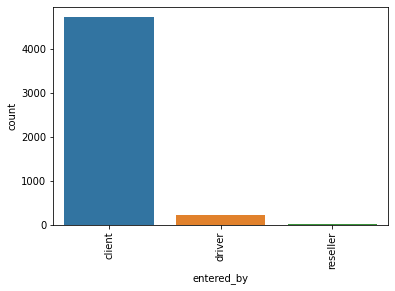

In [27]:
sns.countplot(data=df, x='entered_by')
plt.xticks(rotation=90);

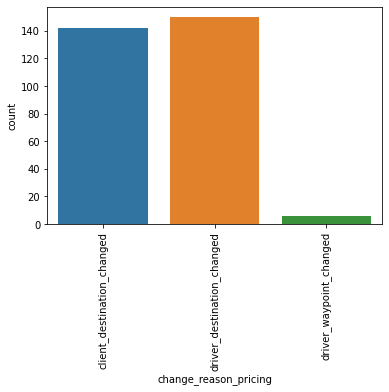

In [28]:
sns.countplot(data=df, x='change_reason_pricing')
plt.xticks(rotation=90);

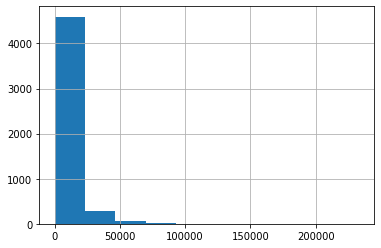

In [21]:
df['distance'].hist();

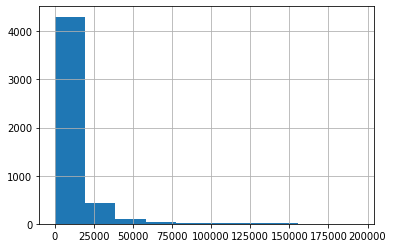

In [22]:
df['metered_price'].hist();

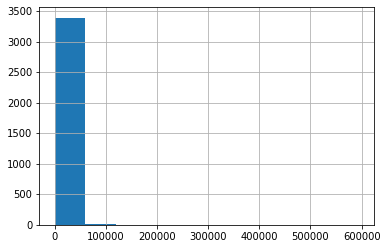

In [23]:
df['upfront_price'].hist();

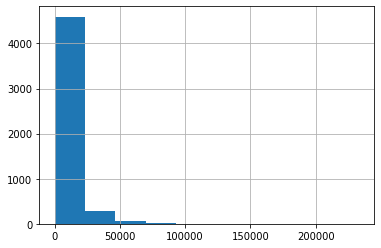

In [24]:
df['distance'].hist();

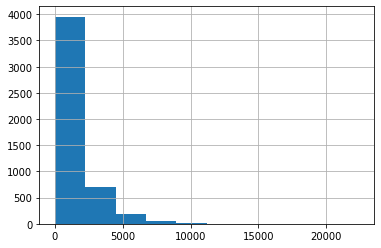

In [25]:
df['duration'].hist();

In [30]:
df['device_name'].value_counts()

TECNO MOBILE LIMITED TECNO B1p    108
HMD Global Nokia 2.2               98
iPhone8,1                          91
TECNO F3                           86
HUAWEI MAR-LX1A                    73
                                 ... 
Samsung SM-N920V                    1
Samsung SM-G925T                    1
Samsung SM-G925A                    1
Xiaomi Redmi Note 5A Prime          1
Xiaomi Redmi Note 5A                1
Name: device_name, Length: 497, dtype: int64

In [23]:
df['rider_app_version'].value_counts()

CI.4.17    723
CI.4.19    624
CA.5.44    560
CA.5.43    406
CA.5.42    365
          ... 
CA.4.44      1
CI.3.81      1
CI.3.44      1
CI.3.62      1
CI.3.93      1
Name: rider_app_version, Length: 114, dtype: int64

In [32]:
pd.crosstab(df['device_name'], df['overpaid_ride_ticket'])

overpaid_ride_ticket,0,1
device_name,,
Alps F9 Pro,10,0
Alps NODROPOUT T25,1,0
Alps TECNO B1p,1,0
Asus ASUS_A002,5,0
Asus ASUS_X00TD,3,0
...,...,...
"iPhone8,1",90,1
"iPhone8,2",18,0
"iPhone8,4",35,0


## Data analysis using machine learning model

In [34]:
df['calc_created']

0      2020-02-02 03:37:31
1      2020-02-08 02:26:19
2      2020-02-08 11:50:35
3      2020-02-05 06:34:54
4      2020-02-13 17:31:24
               ...        
4938   2020-03-07 17:42:34
4939   2020-02-22 18:15:45
4940   2020-03-12 23:08:31
4941   2020-03-08 20:15:04
4942   2020-02-09 07:21:22
Name: calc_created, Length: 4943, dtype: datetime64[ns]

In [37]:
# Converting to int
df['dt_unix'] = df['calc_created'].astype(int) / 10**9

In [38]:
df['dt_unix']

0       1.580615e+09
1       1.581129e+09
2       1.581163e+09
3       1.580884e+09
4       1.581615e+09
            ...     
4938    1.583603e+09
4939    1.582395e+09
4940    1.584055e+09
4941    1.583699e+09
4942    1.581233e+09
Name: dt_unix, Length: 4943, dtype: float64

In [39]:
df.isna().mean()

order_id_new             0.000000
order_try_id_new         0.000000
calc_created             0.000000
metered_price            0.004046
upfront_price            0.310338
distance                 0.000000
duration                 0.000000
gps_confidence           0.000000
entered_by               0.000000
b_state                  0.000000
dest_change_number       0.000000
prediction_price_type    0.004046
predicted_distance       0.004046
predicted_duration       0.004046
change_reason_pricing    0.939713
ticket_id_new            0.000000
device_token             1.000000
rider_app_version        0.003237
order_state              0.000000
order_try_state          0.000000
driver_app_version       0.000000
driver_device_uid_new    0.000000
device_name              0.000000
eu_indicator             0.000000
overpaid_ride_ticket     0.000000
fraud_score              0.558163
dt_unix                  0.000000
dtype: float64

In [40]:
df = df[(~df['prediction_price_type'].isna())&(~df['rider_app_version'].isna())].copy()

In [41]:
train = df.sample(frac=0.7,random_state=42).copy()

In [42]:
val = df[~df.index.isin(train.index)].copy()

In [43]:
len(train)

3446

In [44]:
len(val)

1477

In [45]:
len(train)+len(val)

4923

In [46]:
len(df)

4923

In [47]:
df.select_dtypes(include='object').columns

Index(['entered_by', 'b_state', 'prediction_price_type',
       'change_reason_pricing', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'device_name'],
      dtype='object')

In [48]:
X_col = ['order_id_new', 'order_try_id_new', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'fraud_score',
       'dt_unix']
y_col = ['overpaid_ride_ticket']
cat_features = ['entered_by', 'b_state', 'prediction_price_type',
        'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'device_name']

In [49]:
model = CatBoostClassifier(learning_rate=0.005,
                           eval_metric='AUC',
                           cat_features=cat_features,verbose=100)

In [50]:
model.fit(train[X_col],train[y_col],
          eval_set=(val[X_col],val[y_col]))

0:	test: 0.8134606	best: 0.8134606 (0)	total: 63.2ms	remaining: 1m 3s
100:	test: 0.8499669	best: 0.8499669 (99)	total: 357ms	remaining: 3.18s
200:	test: 0.8571984	best: 0.8572200 (198)	total: 682ms	remaining: 2.71s
300:	test: 0.8617531	best: 0.8617531 (300)	total: 991ms	remaining: 2.3s
400:	test: 0.8630771	best: 0.8634728 (327)	total: 1.31s	remaining: 1.96s
500:	test: 0.8635340	best: 0.8639154 (492)	total: 1.65s	remaining: 1.64s
600:	test: 0.8622244	best: 0.8640521 (513)	total: 2s	remaining: 1.33s
700:	test: 0.8621237	best: 0.8640521 (513)	total: 2.35s	remaining: 1s
800:	test: 0.8625842	best: 0.8640521 (513)	total: 2.72s	remaining: 675ms
900:	test: 0.8629584	best: 0.8640521 (513)	total: 3.06s	remaining: 337ms
999:	test: 0.8630519	best: 0.8640521 (513)	total: 3.4s	remaining: 0us

bestTest = 0.8640520665
bestIteration = 513

Shrink model to first 514 iterations.


In [51]:
model.predict_proba(val[X_col])

array([[0.98799898, 0.01200102],
       [0.83894529, 0.16105471],
       [0.94108298, 0.05891702],
       ...,
       [0.9832305 , 0.0167695 ],
       [0.94981749, 0.05018251],
       [0.98463143, 0.01536857]])

In [52]:
fi = pd.DataFrame({'feature':X_col,'fi':model.feature_importances_})

In [53]:
fi.sort_values('fi',ascending=False)

,feature,fi
2,metered_price,13.959086
10,prediction_price_type,11.959423
21,eu_indicator,11.573707
22,fraud_score,8.224713
20,device_name,7.169111
6,gps_confidence,6.821643
5,duration,6.505697
18,driver_app_version,4.982664
4,distance,4.202336
3,upfront_price,4.023868


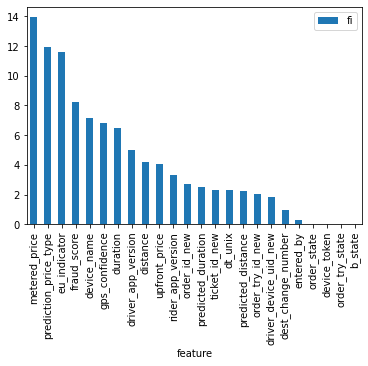

In [55]:
fi.sort_values('fi',ascending=False).set_index('feature').plot(kind='bar');

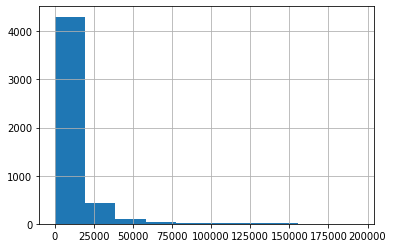

In [57]:
df['metered_price'].hist();

In [60]:
df['metered_price_bin'] = pd.qcut(df['metered_price'], 5)

In [61]:
df['metered_price_bin']

0              (1.999, 4.72]
1               (4.72, 8.25]
2              (1.999, 4.72]
3       (13835.1, 194483.52]
4       (13835.1, 194483.52]
                ...         
4938          (8.25, 6000.0]
4939       (6000.0, 13835.1]
4940            (4.72, 8.25]
4941           (1.999, 4.72]
4942    (13835.1, 194483.52]
Name: metered_price_bin, Length: 4923, dtype: category
Categories (5, interval[float64, right]): [(1.999, 4.72] < (4.72, 8.25] < (8.25, 6000.0] < (6000.0, 13835.1] < (13835.1, 194483.52]]

In [62]:
df['metered_price_bin'].value_counts()

(8.25, 6000.0]          1291
(1.999, 4.72]            992
(13835.1, 194483.52]     985
(4.72, 8.25]             978
(6000.0, 13835.1]        677
Name: metered_price_bin, dtype: int64

In [63]:
df.groupby('metered_price_bin')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
metered_price_bin,,
"(1.999, 4.72]",992,0.000000
"(4.72, 8.25]",978,0.005112
"(8.25, 6000.0]",1291,0.040279
"(6000.0, 13835.1]",677,0.138848
"(13835.1, 194483.52]",985,0.188832


In [64]:
df.groupby('prediction_price_type')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
prediction_price_type,,
prediction,1279,0.173573
upfront,3432,0.032634
upfront_destination_changed,208,0.014423
upfront_waypoint_changed,4,0.000000
